In [44]:
# Define input dir used by cleanup_and_merge
INPUT_DIR = "../study/results"
FIGURE_PATH_AND_NAME_PREFIX = "../figures/Fig"


import os
import json
from matplotlib import pyplot as plt
from collections import Counter, defaultdict
import json
import numpy as np
from typing import *


paper_fig_dir = "../figures/"
path_to_results = os.path.join(INPUT_DIR, 'test_Results_cleaned+mintime+fullAtt.json')


navyblue75 = "#418dcc"
navyblue50 = "#7eafdc"

THRESHOLD = 1
THRESHOLD_SEC1 = 0

In [45]:
with open(os.path.join(INPUT_DIR, "answers_by_user.json"), "r") as f:
    evaluations = json.load(f)


def iterate_runs():
    for run in evaluations.values():
        for attempt in range(6):
            attempt_run = [r for r in run if r["attempt"] == attempt]
            if len(attempt_run) == 0:
                continue
            yield attempt_run


def count_correct_cls(data):
    correct = []
    for run in data:
        correct.append(sum(1 if s["taskSolvedCorrectly"] else 0 for s in run))
    return correct


correct_progs = set()
buggy_progs = set()

for x in iterate_runs():
    for y in x:
        if y["expectedAnswer"] > 0:
            buggy_progs.add(y["ProgrammID"])
        else:
            correct_progs.add(y["ProgrammID"])

def iterate_examples():
    with open("../study/detector-results/gnn.jsonl", "r") as lines:
        for line in lines:
            yield json.loads(line)


def iterate_transformer_examples():
    with open("../study/detector-results/transformer.jsonl", "r") as lines:
        for line in lines:
            yield json.loads(line)


class ClassificationAndLoc():
    def __init__(this, classification, loc):
        this.classification = classification
        this.loc = loc


answers_by_task = defaultdict(list)
task_by_token = {}
program_id_to_stats = {}

for user_answers in iterate_runs():
    for answer in user_answers:
        prog = answer['ProgrammID']
        answers_by_task[prog].append(ClassificationAndLoc(
            answer['taskSolvedCorrectly'], answer['correctLineNumber']))
        task_by_token[prog] = (
            answer['token'], answer['expectedAnswer'], answer["program"].count('\n'))
        program_id_to_stats[prog] = (
            answer['token'],  answer["program"].count('\n'))


# Other forms of aggregation for "the developers decision"
As stated in the paper, we aggregated the answer of developers answers as majority-decision and did not consider cases where no majority exists (ties).
We additionally had a look at two different strategies for "tie-breaking": 
(1) optimistic: A tie is counted as correct classification
(2) pessimistic: A tie is counted as incorrect classification

Below, we present the Figure 6 from the paper in three versions:
1. Without tie breaking
2. optimistic tie breaking
3. pessimistic tie breaking

We can see that there is no significant difference between the three strategies.

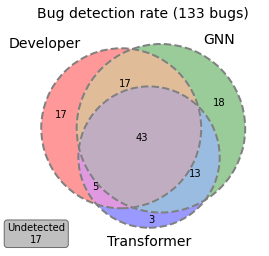

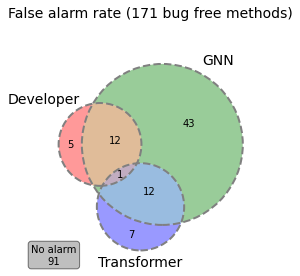

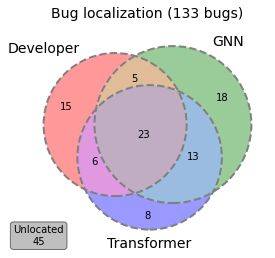

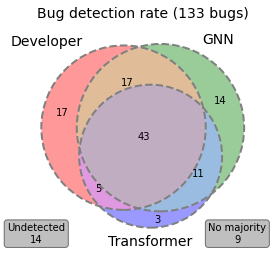

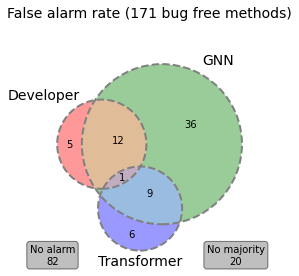

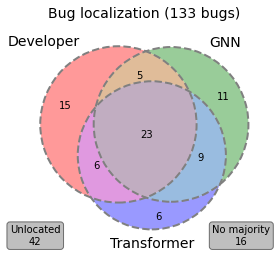

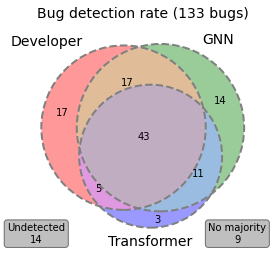

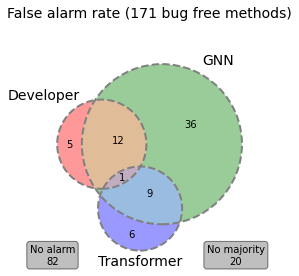

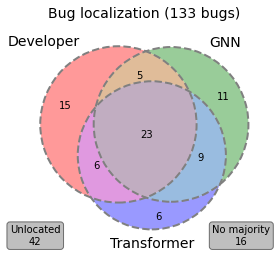

In [53]:
from collections import Counter
from matplotlib_venn import venn3, venn3_circles




def hm_venn3(subsets, set_labels, outside = 0, title = None, title_pad = None, outside_label = "Undetected", no_majority = 0):
    total = sum(subsets) + outside + no_majority

    splt, ax = plt.subplots()

    vd3 = venn3(subsets = subsets,
                    set_labels = set_labels)
    
    for text in vd3.set_labels:
        if text is None: continue
        text.set_fontsize(14)
    for text in vd3.subset_labels:
        if text is None: continue
        text.set_fontsize(10)

    venn3_circles(subsets = subsets,
                    linestyle="--",
                    linewidth=2, color="grey")
    
    if title is not None:
        plt.title(title % total, fontsize = 14, pad = title_pad)

    dy = 0.05

    if outside > 0:
        text = f"{outside_label}\n{outside}"
        props = dict(boxstyle='round', facecolor='grey', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(0.05, dy, text, transform=ax.transAxes, fontsize=10,
                verticalalignment='center',
                 horizontalalignment='center',
                bbox=props)

    if no_majority > 0:
        text = f"No majority\n{no_majority}"
        props = dict(boxstyle='round', facecolor='grey', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(0.90, dy, text, transform=ax.transAxes, fontsize=10,
                verticalalignment='center',
                 horizontalalignment='center',
                bbox=props)


def generate_fig6(ignore_ties = True, count_ties_as_majority = False):
    
    count_ties_as_majority = False

    THRESHOLD = 1

    compare_stats = {}

    for run in iterate_runs():
        for answer in run:
            program_id = answer["ProgrammID"]

            if program_id not in compare_stats:
                compare_stats[program_id] = {"votes": [], "pure_votes": []}

            task_solved  = answer["taskSolvedCorrectly"]
            correct_line = answer["correctLineNumber"] 
            line_number  = answer["lineNumberOfError"]

            compare_stats[program_id]["votes"].append(
                (task_solved, correct_line)
            )

            compare_stats[program_id]["pure_votes"].append(
                (line_number > 0, line_number)
            )

            compare_stats[program_id]["gt"] = answer["expectedAnswer"]
            compare_stats[program_id]["program"] = answer["program"]

    for key in list(compare_stats.keys()):
        if len(compare_stats[key]["votes"]) <= THRESHOLD:
            del compare_stats[key]

    for task_id, machine_answer in enumerate(iterate_examples()):    
        if task_id not in compare_stats: continue

        compare_stats[task_id]["predictions"] = machine_answer["predictions"]

    for task_id, transformer_answer in enumerate(iterate_transformer_examples()):
        if task_id not in compare_stats: continue

        compare_stats[task_id]["transformer_predictions"] = transformer_answer["predictions"]


        


    all_correct   = 0

    human_correct = 0
    ml_correct    = 0
    tr_correct    = 0

    human_ml_correct = 0
    human_tr_correct = 0
    ml_tr_correct    = 0

    all_failed = 0
    count_all = 0

    no_majority = 0


    for results in compare_stats.values():
        if results["gt"] < 0: continue
        vote_count = Counter([v[0] for v in results["votes"]])

        if ignore_ties and vote_count[True] == vote_count[False]: 
            no_majority += 1
            continue
        count_all += 1
        
        if count_ties_as_majority:
            human_is_correct = vote_count[True] >= vote_count[False]
        else: 
            human_is_correct = vote_count[True] > vote_count[False]

        prediction = results["predictions"][0]
        ml_is_correct = prediction["buggy"] == (results["gt"] > 0)

        tr_prediction = results["transformer_predictions"][0]
        tr_is_correct = tr_prediction["buggy"] == (results["gt"] > 0)

        if human_is_correct:
            if ml_is_correct:
                if tr_is_correct:
                    all_correct += 1
                else:
                    human_ml_correct += 1
            else:
                if tr_is_correct:
                    human_tr_correct += 1
                else:
                    human_correct += 1
        else:
            if ml_is_correct:
                if tr_is_correct:
                    ml_tr_correct += 1
                else:
                    ml_correct += 1
            else:
                if tr_is_correct:
                    tr_correct += 1
                else:
                    all_failed += 1

    hm_venn3(
    subsets = (human_correct, ml_correct, human_ml_correct, tr_correct, human_tr_correct, ml_tr_correct, all_correct),
    set_labels = ("Developer", "GNN", "Transformer"),
    outside = all_failed,
    title = "Bug detection rate (%d bugs)",
    no_majority = no_majority,
    title_pad = 9
    )

        
    all_correct   = 0

    human_correct = 0
    ml_correct    = 0
    tr_correct    = 0

    human_ml_correct = 0
    human_tr_correct = 0
    ml_tr_correct    = 0

    all_failed = 0
    count_all = 0
    no_majority = 0


    for results in compare_stats.values():
        if results["gt"] >= 0: continue
        vote_count = Counter([v[0] for v in results["votes"]])

        if ignore_ties and vote_count[True] == vote_count[False]: 
            no_majority += 1
            continue
        count_all += 1
        
        if count_ties_as_majority:
            human_is_correct = vote_count[False] >= vote_count[True]
        else: human_is_correct =vote_count[False] > vote_count[True]

        prediction = results["predictions"][0]
        ml_is_correct = prediction["buggy"] != (results["gt"] > 0)

        tr_prediction = results["transformer_predictions"][0]
        tr_is_correct = tr_prediction["buggy"] != (results["gt"] > 0)

        if human_is_correct:
            if ml_is_correct:
                if tr_is_correct:
                    all_correct += 1
                else:
                    human_ml_correct += 1
            else:
                if tr_is_correct:
                    human_tr_correct += 1
                else:
                    human_correct += 1
        else:
            if ml_is_correct:
                if tr_is_correct:
                    ml_tr_correct += 1
                else:
                    ml_correct += 1
            else:
                if tr_is_correct:
                    tr_correct += 1
                else:
                    all_failed += 1


    hm_venn3(
    subsets = (human_correct, ml_correct, human_ml_correct, tr_correct, human_tr_correct, ml_tr_correct, all_correct),
    set_labels = ("Developer", "GNN", "Transformer"),
    outside = all_failed,
    title = "False alarm rate (%d bug free methods)",
    outside_label = "No alarm",
    no_majority = no_majority,
    title_pad = 31,
    )



    all_correct   = 0

    human_correct = 0
    ml_correct    = 0
    tr_correct    = 0

    human_ml_correct = 0
    human_tr_correct = 0
    ml_tr_correct    = 0

    all_failed = 0
    count_all = 0
    all_missclassified =0

    no_majority = 0

    for results in compare_stats.values():
        if results["gt"] < 0: continue
        vote_count = Counter([v[1] for v in results["votes"]])
        if ignore_ties and vote_count[True] == vote_count[False]: 
            no_majority += 1
            continue
        count_all += 1
        
        if count_ties_as_majority:
            human_is_correct = vote_count[True] >= vote_count[False]
        else: human_is_correct = vote_count[True] > vote_count[False]

        prediction = results["predictions"][0]
        ml_is_correct = prediction["line_num"] == results["gt"]

        tr_prediction = results["transformer_predictions"][0]
        tr_is_correct = tr_prediction["line_num"] == results["gt"]
        

        if human_is_correct:
            if ml_is_correct:
                if tr_is_correct:
                    all_correct += 1
                else:
                    human_ml_correct += 1
            else:
                if tr_is_correct:
                    human_tr_correct += 1
                else:
                    human_correct += 1
        else:
            if ml_is_correct:
                if tr_is_correct:
                    ml_tr_correct += 1
                else:
                    ml_correct += 1
            else:
                if tr_is_correct:
                    tr_correct += 1
                else:
                    ctr = Counter([v[0] for v in results["votes"]])
                    if ctr[False] > ctr[True] : #and  prediction["buggy"] and tr_prediction["buggy"] :
                        all_missclassified +=1
                    all_failed += 1



    hm_venn3(
    subsets = (human_correct, ml_correct, human_ml_correct, tr_correct, human_tr_correct, ml_tr_correct, all_correct),
    set_labels = ("Developer", "GNN", "Transformer"),
    outside = all_failed,
    title = "Bug localization (%d bugs)",
    outside_label = "Unlocated",
    no_majority = no_majority,
    title_pad = 11,
    )


generate_fig6(False,True)
generate_fig6(True,True)
generate_fig6(True,False)

# Influence of certain attributes from the survey

In the following, we provide a graphical and numerical analysis of the effect off different survey data:
- experience
- age
- field of work 
- codebase
- size of teams
As stated in the paper, the only attribute having an effect is `experience`.  
We first provide some statistical data per group, followed by two line-diagrams, 
each representing the number of correct localizations per class.
The first one shows relative values, the second one absolute (as for some groups only few developers are contained)

In [47]:
from scipy.interpolate import make_interp_spline
import numpy as np
import matplotlib.pyplot as plt


def print_prefiltered_data_line(prefiltered_data, classification_criteria, title, relative=True, safefig=None):
    labels = list(range(0, 9))

    x_val = np.arange(len(labels))
    for i,  dataset in enumerate(prefiltered_data):
        to_process = count_correct_cls(dataset)
        magnitude = []
        abs = len(to_process)
        for j in labels:
            if relative:
                magnitude.append(
                    sum([1 for x in to_process if x == j])/abs*100)
            else:
                magnitude.append(sum([1 for x in to_process if x == j]))
        if relative:
            print("Trials:{},\tAverage {:.3f}, \t median {:.3f}, \tvariance {:.3f} for {}, ".format(
                abs, np.mean(to_process), np.median(to_process),  np.var(to_process), classification_criteria[i]))
        # plot data in grouped manner of bar type
        plt.plot(x_val, magnitude)

    plt.xticks(x_val, labels)
    plt.xlabel("Number of correct cls per trial")
    if relative:
        plt.ylabel("Relative number of trials in %")
    else:
        plt.ylabel("Absolute number of trials")
    plt.title(title)
    plt.legend(classification_criteria)
    plt.show()

### Experiance

Trials:26,	Average 5.269, 	 median 5.500, 	variance 1.966 for <2, 
Trials:53,	Average 5.774, 	 median 6.000, 	variance 1.609 for 2-5, 
Trials:48,	Average 5.854, 	 median 6.000, 	variance 1.375 for >5, 
Trials:127,	Average 5.701, 	 median 6.000, 	variance 1.643 for any, 


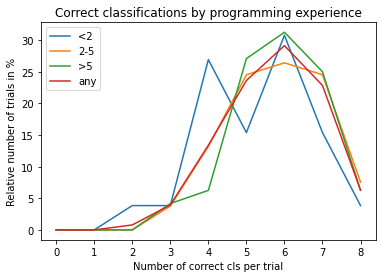

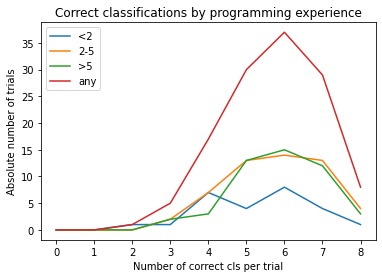

In [48]:
print_prefiltered_data_line([
    [x for x in iterate_runs() if x[0]["exp"] == "2"],
    [x for x in iterate_runs() if x[0]["exp"] == "2-5"],
    [x for x in iterate_runs() if x[0]["exp"] == "5"],
    [x for x in iterate_runs()]
], ["<2", "2-5", ">5", "any"], title="Correct classifications by programming experience")
print_prefiltered_data_line([
    [x for x in iterate_runs() if x[0]["exp"] == "2"],
    [x for x in iterate_runs() if x[0]["exp"] == "2-5"],
    [x for x in iterate_runs() if x[0]["exp"] == "5"],
    [x for x in iterate_runs()]
], ["<2", "2-5", ">5", "any"], title="Correct classifications by programming experience", relative=False)

### Age

(Note that the group >50 consists of 4 participants!)

Trials:74,	Average 5.649, 	 median 6.000, 	variance 1.687 for <30, 
Trials:49,	Average 5.878, 	 median 6.000, 	variance 1.454 for 30-50, 
Trials:4,	Average 4.500, 	 median 4.500, 	variance 1.250 for >50, 
Trials:127,	Average 5.701, 	 median 6.000, 	variance 1.643 for any, 


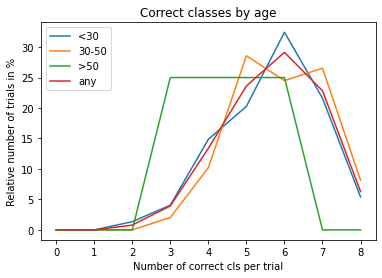

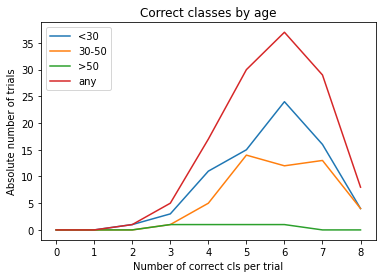

In [49]:
print_prefiltered_data_line([
    [x for x in iterate_runs() if x[0]["age"] == "30"],
    [x for x in iterate_runs() if x[0]["age"] == "31-50"],
    [x for x in iterate_runs() if x[0]["age"] == "50"],
    [x for x in iterate_runs()]
], ["<30", "30-50", ">50", "any"], "Correct classes by age"
)
print_prefiltered_data_line([
    [x for x in iterate_runs() if x[0]["age"] == "30"],
    [x for x in iterate_runs() if x[0]["age"] == "31-50"],
    [x for x in iterate_runs() if x[0]["age"] == "50"],
    [x for x in iterate_runs()]
], ["<30", "30-50", ">50", "any"], "Correct classes by age",relative=False
)

### Field of work

Trials:46,	Average 5.587, 	 median 6.000, 	variance 1.721 for oss, 
Trials:42,	Average 5.667, 	 median 6.000, 	variance 1.651 for others, 
Trials:39,	Average 5.872, 	 median 6.000, 	variance 1.496 for commercial, 
Trials:127,	Average 5.701, 	 median 6.000, 	variance 1.643 for any, 


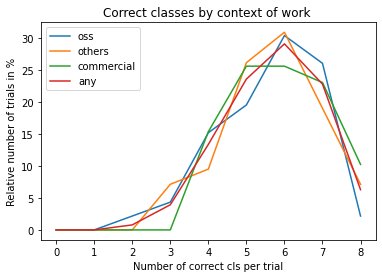

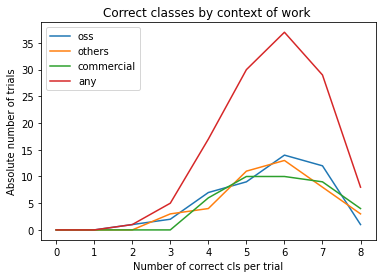

In [50]:

print_prefiltered_data_line([
        [x for x in iterate_runs() if "oss" in x[0]["ctx"]],
        [x for x in iterate_runs() if "others" in x[0]["ctx"]],
        [x for x in iterate_runs() if "commercial" in x[0]["ctx"]],
        [x for x in iterate_runs()],
    ], ["oss", "others", "commercial", "any"], "Correct classes by context of work "
    )

print_prefiltered_data_line([
        [x for x in iterate_runs() if "oss" in x[0]["ctx"]],
        [x for x in iterate_runs() if "others" in x[0]["ctx"]],
        [x for x in iterate_runs() if "commercial" in x[0]["ctx"]],
        [x for x in iterate_runs()],
    ], ["oss", "others", "commercial", "any"], "Correct classes by context of work ",relative=False
    )



### Codebase

Trials:42,	Average 5.810, 	 median 6.000, 	variance 1.916 for others, 
Trials:85,	Average 5.647, 	 median 6.000, 	variance 1.499 for own, 
Trials:127,	Average 5.701, 	 median 6.000, 	variance 1.643 for any, 


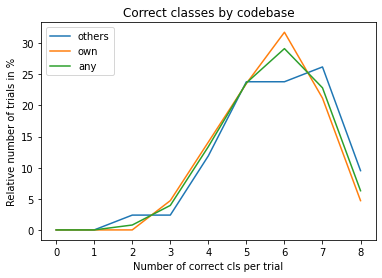

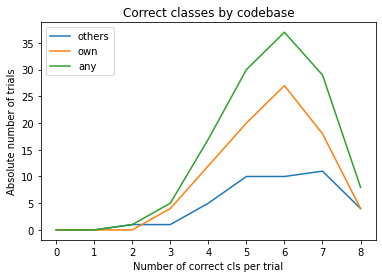

In [51]:

print_prefiltered_data_line([
        [x for x in iterate_runs() if "others" in x[0]["codebase"]],
        [x for x in iterate_runs() if "own" in x[0]["codebase"]],
        [x for x in iterate_runs()],
    ], ["others", "own", "any"], "Correct classes by codebase", 
    )

print_prefiltered_data_line([
        [x for x in iterate_runs() if "others" in x[0]["codebase"]],
        [x for x in iterate_runs() if "own" in x[0]["codebase"]],
        [x for x in iterate_runs()],
    ], ["others", "own", "any"], "Correct classes by codebase", relative=False
    )





### Team size

Again, note that team size `large` contains only 5 participants

Trials:57,	Average 5.632, 	 median 6.000, 	variance 1.952 for alone, 
Trials:65,	Average 5.723, 	 median 6.000, 	variance 1.339 for small, 
Trials:5,	Average 6.200, 	 median 6.000, 	variance 1.760 for large, 
Trials:127,	Average 5.701, 	 median 6.000, 	variance 1.643 for any, 


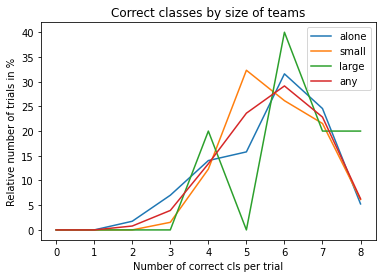

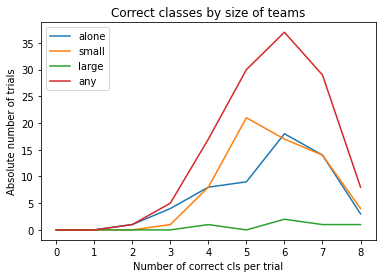

In [52]:

print_prefiltered_data_line([
        [x for x in iterate_runs() if "alone" in x[0]["team"]],
        [x for x in iterate_runs() if "small" in x[0]["team"]],
        [x for x in iterate_runs() if "large" in x[0]["team"]],
        [x for x in iterate_runs()],
    ], ["alone", "small", "large", "any"], "Correct classes by size of teams", 
    )
    
print_prefiltered_data_line([
        [x for x in iterate_runs() if "alone" in x[0]["team"]],
        [x for x in iterate_runs() if "small" in x[0]["team"]],
        [x for x in iterate_runs() if "large" in x[0]["team"]],
        [x for x in iterate_runs()],
    ], ["alone", "small", "large", "any"], "Correct classes by size of teams", relative=False
    )